In [51]:
import numpy as np
import keras
from keras import backend as k 
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

In [27]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['dr','nodr'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['dr','nodr'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['dr','nodr'], batch_size=10)

Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [28]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0] is np.ndarray):
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [29]:
imgs , labels = next(train_batches)

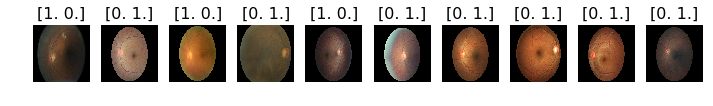

In [30]:
plots(imgs, titles=labels)

In [31]:
vgg16_model = keras.applications.vgg16.VGG16()

In [32]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [33]:
type(vgg16_model)

keras.engine.training.Model

In [34]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [36]:
for layer in model.layers:
    layer.trainable = False 

In [37]:
model.add(Dense(2, activation='softmax'))

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [39]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
model.fit_generator(train_batches, steps_per_epoch=4,
                   validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
 - 34s - loss: 0.7868 - acc: 0.5750 - val_loss: 0.7148 - val_acc: 0.5750
Epoch 2/5
 - 29s - loss: 0.5943 - acc: 0.6250 - val_loss: 0.7835 - val_acc: 0.6250
Epoch 3/5
 - 30s - loss: 0.5978 - acc: 0.6750 - val_loss: 0.8332 - val_acc: 0.5500
Epoch 4/5
 - 29s - loss: 0.6522 - acc: 0.6250 - val_loss: 0.7814 - val_acc: 0.6000
Epoch 5/5
 - 30s - loss: 0.4847 - acc: 0.7500 - val_loss: 0.7390 - val_acc: 0.5750


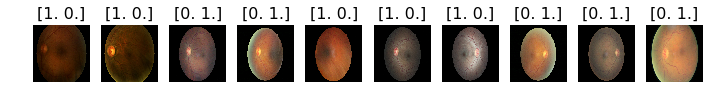

In [41]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [42]:
test_labels = test_labels[:,0]
test_labels

array([1., 1., 0., 0., 1., 1., 1., 0., 0., 0.], dtype=float32)

In [43]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [44]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [45]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

Confusion matrix, without normalization
[[3 2]
 [2 3]]


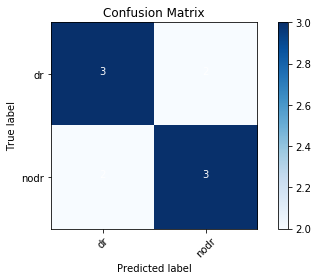

In [49]:
cm_plot_labels = ['dr','nodr']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [50]:
model.save('diabetic_retinopathy.h5')